In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA


#import warnings
#warnings.filterwarnings('ignore')

In [154]:
%matplotlib inline

### Fonctions

In [15]:
def plot_corr_function(df):
    """
    Take a pandas series and plot Auto-correlation function and Partial Auto-correlation
    """
    fig, ax = plt.subplots(2, 1, figsize= [8, 6])
    
    _ = plot_acf(df, color= 'blue', ax= ax[0])
    _ = plot_pacf(df, color= 'blue', ax= ax[1])# _ = est un truc pour éviter d'imprimer 2x le même plot


In [63]:
def get_stationarity(timeseries, window_size= 12 ):
    """
    Take a pandas serie timeseries in to output key indicators of stationarity
    """    
    # rolling statistics
    rolling_mean = timeseries.rolling(window= window_size).mean()
    rolling_std = timeseries.rolling(window= window_size).std()

    # rolling statistics plot
    fig= plt.figure(figsize= (15, 4))
    original = plt.plot(timeseries, color='black', label='Original', alpha= 0.3)
    mean = plt.plot(rolling_mean, color='coral', label='Rolling Mean')
    std = plt.plot(rolling_std, color='teal', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print("Mean MinMax Delta:", rolling_mean.max() - rolling_mean.min())
    print("Std MinMax Delta:", rolling_std.max() - rolling_std.min())
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [29]:
def tfrm_to_MinusMean(PdSeries, window_size= 12):
    """
    Transform a Pandas Series to stationary by substracting value from a rolling mean (deviation from mean).
    Returns a Pandas Series
    
    See why here: (https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7)
    """
    
    df_ravg = PdSeries.rolling(window_size).mean()
    df_minus_mean = PdSeries - df_ravg
    df_minus_mean.dropna(inplace=True)
    return df_minus_mean #, df_ravg

In [39]:
def AIC(PdSeries, order= (1, 0, 1)):
    """
    Take a Pandas series and fit an ARMA model of order= 
    to return Akaike Information Criterion
    """

    # Fit the data to an AR(1) model and print AIC:
    mod_arima = ARIMA(PdSeries, order= order)
    res_arima = mod_arima.fit()
    print("The AIC for an ARIMA{} is: {:5.0f} ".format(order, res_arima.aic))
    return res_arima.aic

In [40]:
def aic_optimize(PdSeries, ar_max_range= 8, ma_max_range= 12):
    """
    Take Pandas series and print Akaike Information Criterion for every order in 
    a range of order, ar(0) to ar(ar_max_range) and ma(0) to ma(ma_max_range).
    Also return a list of all AIC values. 
    """
    ar_ls= np.arange(0, ar_max_range)
    ma_ls= np.arange(0, ma_max_range)
    aic_ls= []
    for i in ar_ls:
        for j in ma_ls:
            aic = AIC(PdSeries, order= (i, 0, j))
            aic
            aic_ls.append(aic)
    return aic_ls

In [20]:
def rolling_window(a, step):
    shape   = a.shape[:-1] + (a.shape[-1] - step + 1, step)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [113]:
def rolwin_ARIMA(df, ARIMA_order= (1,0,1), window_size= 100, initialization='approximate_diffuse'):
    """
    Take a DataFrame and train an ARIMA model on a rolling window to get
    the predicted value, one data point beyond the window.
    
    Returns a DataFrame to compare actual data VS predicted
    """
    
    output_df = pd.DataFrame(df.iloc[window_size : :])
    
    # Créer une liste de np.arrays de valeurs n=100 d'une fenêtre roulante
    r = rolling_window(np.array(df), window_size)

    # Init d'une liste de prédictions
    pred_col = []

    for i in r:
        mod_arma_t = ARIMA(i, order= ARIMA_order)
        res_arma_t = mod_arma_t.fit()

        # Prédire 1 jour au-delà du dataset
        pred_arma_t = res_arma_t.predict(end= len(i) + 1) 
        # Ajouter la prédiction à la liste
        pred_col.append(pred_arma_t[window_size]) 

    output_df['Prediction'] = pred_col[0:-1]
    output_df['Erreur'] = output_df['pct6'] - output_df['Prediction']
    
    return output_df

In [114]:
def rolwin_ARMA(df, ARMA_order= (1,1), window_size= 100, initialization='approximate_diffuse'):
    """
    Take a DataFrame and train an ARIMA model on a rolling window to get
    the predicted value, one data point beyond the window.
    
    Returns a DataFrame to compare actual data VS predicted
    """
    
    output_df = pd.DataFrame(df.iloc[window_size : :])
    
    # Créer une liste de np.arrays de valeurs n=100 d'une fenêtre roulante
    r = rolling_window(np.array(df), window_size)

    # Init d'une liste de prédictions
    pred_col = []

    for i in r:
        mod_arma_t = ARMA(i, order= ARMA_order)
        res_arma_t = mod_arma_t.fit()

        # Prédire 1 jour au-delà du dataset
        pred_arma_t = res_arma_t.predict(end= len(i) + 1) 
        # Ajouter la prédiction à la liste
        pred_col.append(pred_arma_t[window_size]) 

    output_df['Prediction'] = pred_col[0:-1]
    output_df['Erreur'] = output_df['pct6'] - output_df['Prediction']
    
    return output_df

In [22]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

# Donnée historique intra-day
intervale: 30min 
période: mai 2017 à avril 2020

In [2]:
sobey = pd.read_csv('_Input/emp-a.to_intraday-30min_historical-data-04-06-2020.csv')

In [ ]:
loblaw = pd.read_csv('_Input/l.to_intraday-30min_historical-data-04-06-2020.csv')

In [ ]:
metro = pd.read_csv('_Input/mru.to_intraday-30min_historical-data-04-06-2020.csv')

## Data cleaning

In [3]:
# Efface le footer du csv de barchart.com
sobey.drop(labels= 9999, inplace= True)

# Set datetime index
sobey.index = pd.to_datetime(sobey.Time)
sobey.sort_index(inplace= True)
#sobey.set_index('Time', inplace= True)

# Nouvelles colonnes
sobey['Average'] = ( sobey.High + sobey.Low ) / 2
sobey['Week']= sobey.index.week.astype('str')
sobey['Week'] = sobey['Week'].str.slice_replace(0, 0, 'W')
sobey['Quarter']= sobey.index.quarter.astype('str')
sobey['Quarter'] = sobey['Quarter'].str.slice_replace(0, 0, 'Q')

# Changer les data types
sobey["Volume"] = sobey["Volume"].astype('int32')
sobey["Week"] = sobey["Week"].astype('category')
sobey["Quarter"] = sobey["Quarter"].astype('category')

In [ ]:
#ls_pct = ['pct2', 'pct3', 'pct4', 'pct5', 'pct6', 'pct7']
ls_nb = np.arange(2, 8, 1)

sobey['pct'] = sobey['Average'].pct_change() * 100

for i in ls_nb:
    sobey['pct{}'.format(i)] = sobey['Average'].pct_change(i) * 100
    

In [5]:
sobey['pct'] = sobey['Average'].pct_change() * 100
sobey['pct2'] = sobey['Average'].pct_change(2) * 100
sobey['pct3'] = sobey['Average'].pct_change(3) * 100
sobey['pct4'] = sobey['Average'].pct_change(4) * 100
sobey['pct5'] = sobey['Average'].pct_change(5) * 100
sobey['pct6'] = sobey['Average'].pct_change(6) * 100
sobey['pct7'] = sobey['Average'].pct_change(7) * 100
sobey.dropna(inplace= True)

In [55]:
sobey2018 = sobey['2018']

In [56]:
sobey2018.shape

(3497, 17)

In [111]:
sobey2018.head(1)

,Time,Open,High,Low,Last,Change,Volume,Average,Week,Quarter,pct,pct2,pct3,pct4,pct5,pct6,pct7
Time,,,,,,,,,,,,,,,,,
2018-01-02 09:30:00,01/02/18 09:30,24.7,24.7,24.38,24.46,-0.03,14600,24.54,W1,Q1,0.204165,0.30656,0.368098,0.470829,0.553165,0.532569,0.450266


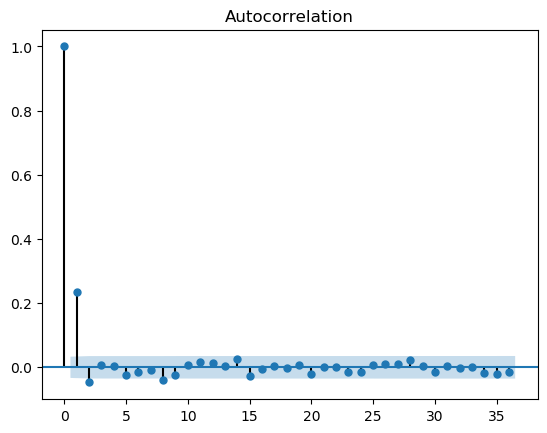

In [57]:
plot_acf(sobey2018.pct)

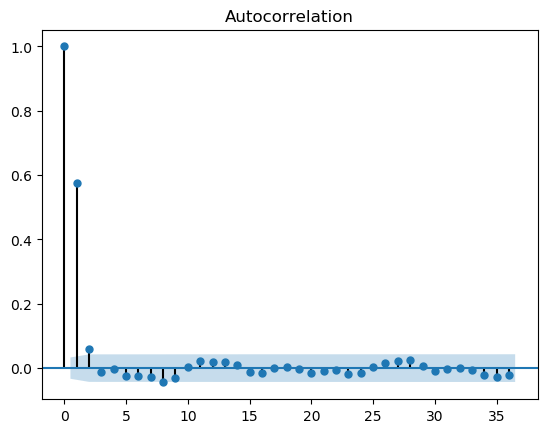

In [58]:
plot_acf(sobey2018.pct2)

In [ ]:
plot_acf(sobey.pct3)

In [ ]:
plot_acf(sobey.pct4)

In [ ]:
plot_acf(sobey.pct5)

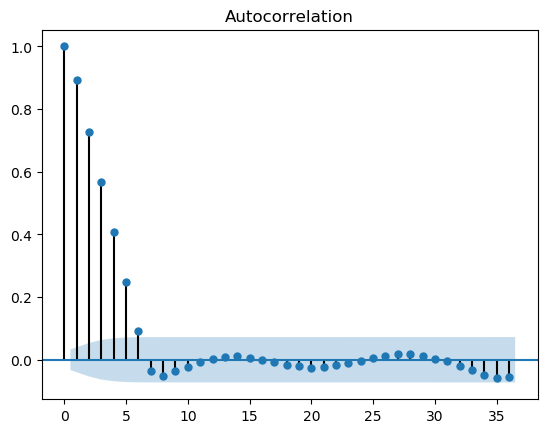

In [59]:
plot_acf(sobey2018.pct7)

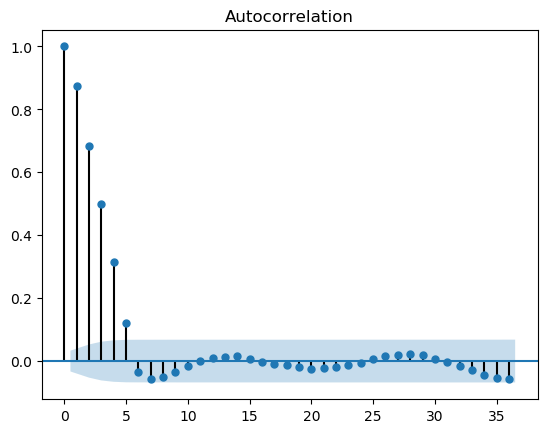

In [60]:
plot_acf(sobey2018.pct6)

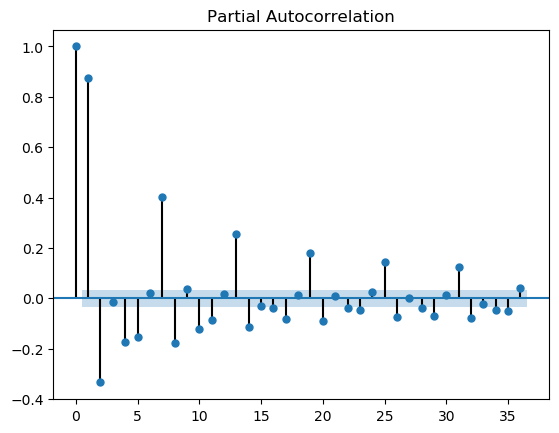

In [61]:
plot_pacf(sobey2018.pct6)

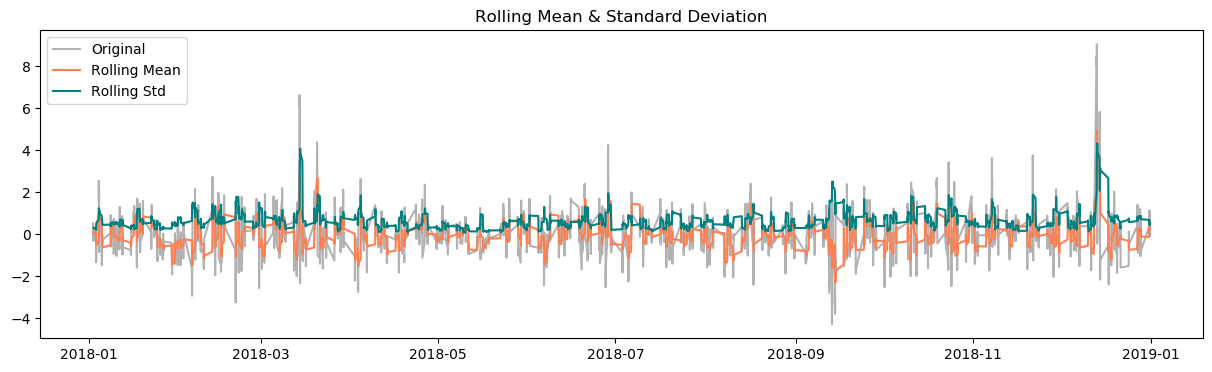

Mean MinMax Delta: 7.221909008762763
Std MinMax Delta: 4.236695220092082
ADF Statistic: -9.250973266908247
p-value: 1.4926126878561675e-15
Critical Values:
	1%: -3.4322380985744103
	5%: -2.862374254158709
	10%: -2.5672140884144015


In [64]:
get_stationarity(sobey2018.pct6)

In [99]:
sobey2018_6_meanDev = tfrm_to_MinusMean(sobey2018['pct6'], window_size= 2)

In [100]:
sobey2018_6_meanDev.dropna()

Time
2018-01-02 10:00:00   -0.174090
2018-01-02 10:30:00    0.143220
2018-01-02 11:00:00   -0.010466
2018-01-02 11:30:00   -0.010357
2018-01-02 12:00:00   -0.122718
                         ...   
2018-12-31 14:00:00    0.176925
2018-12-31 14:30:00    0.024875
2018-12-31 15:00:00   -0.080085
2018-12-31 15:30:00   -0.088634
2018-12-31 16:00:00   -0.158404
Name: pct6, Length: 3496, dtype: float64

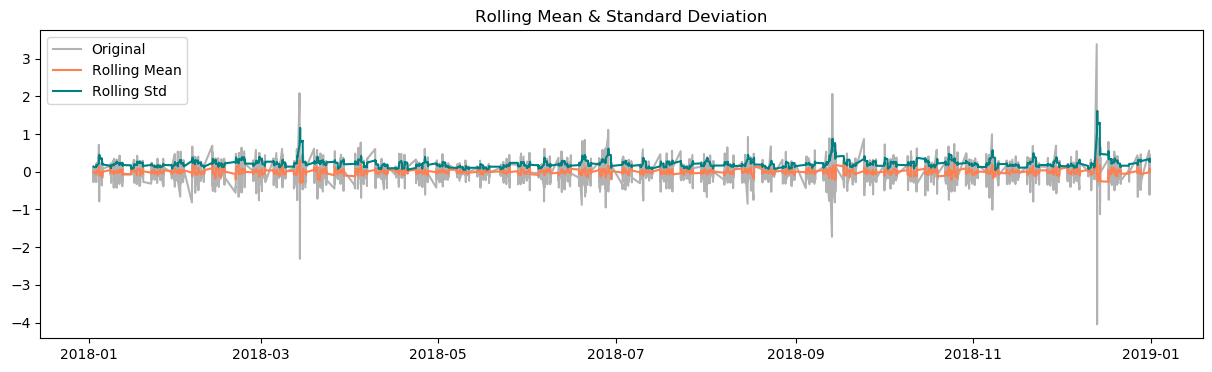

Mean MinMax Delta: 0.6463649930601496
Std MinMax Delta: 1.565756830410623
ADF Statistic: -16.844573479689377
p-value: 1.1311444894104605e-29
Critical Values:
	1%: -3.4322386438846837
	5%: -2.862374495027001
	10%: -2.567214216645948


In [101]:
get_stationarity(sobey2018_6_meanDev)

In [41]:
aic6_meanDev = aic_optimize(sobey6_meanDev, ar_max_range= 5, ma_max_range= 11)

The AIC for an ARMA(0, 0, 0) is: 29006 
The AIC for an ARMA(0, 0, 1) is: 20579 
The AIC for an ARMA(0, 0, 2) is: 16738 
The AIC for an ARMA(0, 0, 3) is: 16545 
The AIC for an ARMA(0, 0, 4) is: 16103 
The AIC for an ARMA(0, 0, 5) is: 10351 
The AIC for an ARMA(0, 0, 6) is: 10241 
The AIC for an ARMA(0, 0, 7) is: 10235 
The AIC for an ARMA(0, 0, 8) is: 10230 
The AIC for an ARMA(0, 0, 9) is: 10234 
The AIC for an ARMA(0, 0, 10) is: 10603 
The AIC for an ARMA(1, 0, 0) is: 16780 
The AIC for an ARMA(1, 0, 1) is: 16216 
The AIC for an ARMA(1, 0, 2) is: 16089 
The AIC for an ARMA(1, 0, 3) is: 15510 
The AIC for an ARMA(1, 0, 4) is: 14618 
The AIC for an ARMA(1, 0, 5) is: 10269 
The AIC for an ARMA(1, 0, 6) is:  9939 
The AIC for an ARMA(1, 0, 7) is:  9629 
The AIC for an ARMA(1, 0, 8) is:  9616 
The AIC for an ARMA(1, 0, 9) is:  9607 
The AIC for an ARMA(1, 0, 10) is:  9613 
The AIC for an ARMA(2, 0, 0) is: 16048 
The AIC for an ARMA(2, 0, 1) is: 15317 
The AIC for an ARMA(2, 0, 2) is: 15158

In [36]:
AIC(sobey6_meanDev, (2,5))

The AIC for an ARMA(2, 5) is: 10232 


10231.859570065924

In [37]:
AIC(sobey6_meanDev, (2,7))

The AIC for an ARMA(2, 7) is:  9574 


9573.938745793086

In [38]:
AIC(sobey6_meanDev, (3,7))

The AIC for an ARMA(3, 7) is:  9554 


9553.913056439942

In [42]:
AIC(sobey6_meanDev, (5,0,7))

The AIC for an ARMA(5, 0, 7) is:  9583 


9582.999811922968

In [43]:
AIC(sobey6_meanDev, (5,0,10))

The AIC for an ARMA(5, 0, 10) is:  9556 


9556.086351273076

In [44]:
AIC(sobey6_meanDev, (3,0,13))

The AIC for an ARMA(3, 0, 13) is:  9560 


9560.412161163285

In [45]:
_= AIC(sobey6_meanDev, (5,0,13))

The AIC for an ARMA(5, 0, 13) is:  9571 


In [102]:
_= AIC(sobey2018_6_meanDev, (2,0,7))

The AIC for an ARMA(2, 0, 7) is: -2192 


In [46]:
plt.figure(figsize= (8, 5))
_= plt.plot(aic6_meanDev[0:11], color='indigo', label='ARMA(0, x)', alpha= 0.5)
_= plt.plot(aic6_meanDev[11:22], color='salmon', label='ARMA(1, x)', alpha= 0.5)
_= plt.plot(aic6_meanDev[22:33], color='black', label='ARMA(2, x)', alpha= 0.5)
_= plt.plot(aic6_meanDev[33:44], color='gold', label='ARMA(3, x)', alpha= 0.5)
_= plt.plot(aic6_meanDev[44:55], color='olive', label='ARMA(4, x)', alpha= 0.5)
_= plt.legend(loc='best')
_= plt.title('AIC de modèles ARMA sur une série de paramètres ')

In [103]:
range1= list(np.arange(25, 176, 25))
ls_mean1= []
ls_std1= []

for i in range1:
    # Entrainer un modèle ARIMA sur un rolling window
    test_df_roll= rolwin_ARIMA(sobey2018_6_meanDev.iloc[:500], ARIMA_order= (5, 0, 10), window_size= i)
    ls_mean.append(test_df_roll['Erreur'].mean())
    ls_std.append(test_df_roll['Erreur'].std())
    
    print("___{} sur un Rolling window de: {}___".format('BA_2016_pct5_meanDev', i))
    print("Moyenne du delta Réel vs Prédiction: {:.3f} ".format(test_df_roll['Erreur'].mean()))
    print("Écart type du delta Réel vs Prédiction: {:.3f}".format(test_df_roll['Erreur'].std()))
    print("Écart type des données: {:.3f}".format(test_df_roll['Adj Close'].std()))
    #_= test_df_roll[['Adj Close', 'Prediction']].plot()

LinAlgError: LU decomposition error.

In [117]:
df_roll_temp= rolwin_ARIMA(sobey2018_6_meanDev.iloc[:250], ARIMA_order= (5, 0, 10), window_size= 118)

In [107]:
sobey2018_6_meanDev

Time
2018-01-02 10:00:00   -0.174090
2018-01-02 10:30:00    0.143220
2018-01-02 11:00:00   -0.010466
2018-01-02 11:30:00   -0.010357
2018-01-02 12:00:00   -0.122718
                         ...   
2018-12-31 14:00:00    0.176925
2018-12-31 14:30:00    0.024875
2018-12-31 15:00:00   -0.080085
2018-12-31 15:30:00   -0.088634
2018-12-31 16:00:00   -0.158404
Name: pct6, Length: 3496, dtype: float64

In [131]:
df_roll_temp

,pct6,Prediction,Erreur
Time,,,
2018-01-12 13:00:00,-0.060174,-0.204801,0.144627
2018-01-12 13:30:00,-0.250223,-0.211216,-0.039007
2018-01-12 14:00:00,0.229744,0.187191,0.042553
2018-01-12 14:30:00,0.181567,0.214946,-0.033379
2018-01-12 15:00:00,-0.000101,0.085819,-0.085920
...,...,...,...
2018-01-25 13:30:00,0.164528,0.117487,0.047041
2018-01-25 14:00:00,0.087602,0.098017,-0.010414
2018-01-25 14:30:00,0.117346,0.143197,-0.025850


In [158]:
sobey2018_6_meanDev = tfrm_to_MinusMean(sobey2018['pct6'], window_size= 2)
sobey2018_6_meanDev.dropna(inplace= True)

In [136]:
# Stiching all together
#sobey2018_6_meanDev= pd.concat([df_roll_temp, sobey2018_6_meanDev.iloc[118 :]], axis= 1)
#BA_2016_pct5_meanDev.columns = ['pct5_var', 'Pred_var', 'Erreur', 'RollAvg12_pct5', 'pct5']

# Selon système d'équation résolut sur papier
sobey2018_6_meanDev = df_roll_temp.copy()
sobey2018_6_meanDev['Pred_pct6'] = sobey2018_6_meanDev['pct6'] - sobey2018_6_meanDev['Erreur']

In [138]:
# Créer une valeur bool indiquant une différence entre la direction du retour prédit vs actuel
sobey2018_6_meanDev['Erreur_Dir'] = ((sobey2018_6_meanDev['pct6'] < 0) & (sobey2018_6_meanDev['Pred_pct6'] > 0)) | ((sobey2018_6_meanDev['pct6'] > 0) & (sobey2018_6_meanDev['Pred_pct6'] < 0))

In [139]:
sobey2018_6_meanDev

,pct6,Prediction,Erreur,Pred_pct6,Erreur_Dir
Time,,,,,
2018-01-12 13:00:00,-0.060174,-0.204801,0.144627,-0.204801,False
2018-01-12 13:30:00,-0.250223,-0.211216,-0.039007,-0.211216,False
2018-01-12 14:00:00,0.229744,0.187191,0.042553,0.187191,False
2018-01-12 14:30:00,0.181567,0.214946,-0.033379,0.214946,False
2018-01-12 15:00:00,-0.000101,0.085819,-0.085920,0.085819,True
...,...,...,...,...,...
2018-01-25 13:30:00,0.164528,0.117487,0.047041,0.117487,False
2018-01-25 14:00:00,0.087602,0.098017,-0.010414,0.098017,False
2018-01-25 14:30:00,0.117346,0.143197,-0.025850,0.143197,False


Moyenne de l'erreur: -0.005% 
Écart type de l'erreur: 0.125%
____________________________
Retour moyen actuel: -0.000% 
Retour moyen prédit: 0.005% 
Écart type des retours actuels: 0.173%
Écart type des retours prédits: 0.139% 


[]

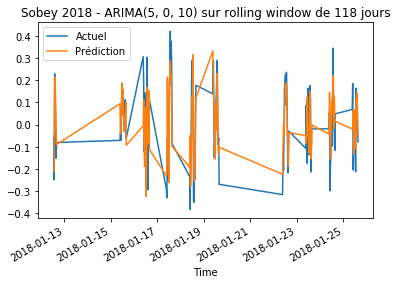

In [155]:
print("Moyenne de l'erreur: {:.3f}% ".format(sobey2018_6_meanDev['Erreur'].mean()))
print("Écart type de l'erreur: {:.3f}%".format(sobey2018_6_meanDev['Erreur'].std()))
print('____________________________')
print("Retour moyen actuel: {:.3f}% ".format(sobey2018_6_meanDev['pct6'].mean()))
print("Retour moyen prédit: {:.3f}% ".format(sobey2018_6_meanDev['Pred_pct6'].mean()))
print("Écart type des retours actuels: {:.3f}%".format(sobey2018_6_meanDev['pct6'].std()))
print("Écart type des retours prédits: {:.3f}% ".format(sobey2018_6_meanDev['Pred_pct6'].std()))
_= sobey2018_6_meanDev[['pct6', 'Pred_pct6']].plot()
_= plt.legend(('Actuel', 'Prédiction'))
_= plt.title('Sobey 2018 - ARIMA(5, 0, 10) sur rolling window de 118 jours')
plt.plot()

In [140]:
# Quel est le ratio de prédictions dans la bonne direction (False)
sobey2018_6_meanDev['Erreur_Dir'].value_counts(normalize= True)

False    0.765152
True     0.234848
Name: Erreur_Dir, dtype: float64

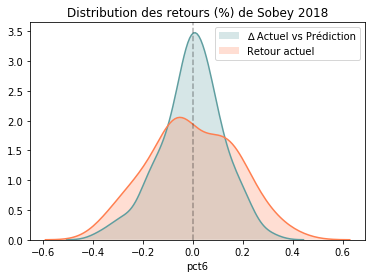

In [156]:
fig= plt.figure(figsize= (6, 4))
_= sns.distplot(sobey2018_6_meanDev['Erreur'], hist=False, color="cadetblue", kde_kws={"shade": True})
_= sns.distplot(sobey2018_6_meanDev['pct6'], hist=False, color="coral", kde_kws={"shade": True})
_= plt.legend(('∆ Actuel vs Prédiction', 'Retour actuel'))
_= plt.axvline(x= 0, linestyle='--', color='k', alpha= 0.3)
_= plt.title('Distribution des retours (%) de Sobey 2018')

In [147]:
sobey2018_6_meanDev

,pct6,Prediction,Erreur,Pred_pct6,Erreur_Dir
Time,,,,,
2018-01-12 13:00:00,-0.060174,-0.204801,0.144627,-0.204801,False
2018-01-12 13:30:00,-0.250223,-0.211216,-0.039007,-0.211216,False
2018-01-12 14:00:00,0.229744,0.187191,0.042553,0.187191,False
2018-01-12 14:30:00,0.181567,0.214946,-0.033379,0.214946,False
2018-01-12 15:00:00,-0.000101,0.085819,-0.085920,0.085819,True
...,...,...,...,...,...
2018-01-25 13:30:00,0.164528,0.117487,0.047041,0.117487,False
2018-01-25 14:00:00,0.087602,0.098017,-0.010414,0.098017,False
2018-01-25 14:30:00,0.117346,0.143197,-0.025850,0.143197,False


In [ ]:
sobey2018_6_meanDev = tfrm_to_MinusMean(sobey2018['pct6'], window_size= 2)
sobey2018_6_meanDev.dropna(inplace= True)

In [159]:
df_roll_temp= rolwin_ARIMA(sobey2018_6_meanDev.iloc[:250], ARIMA_order= (2, 0, 7), window_size= 118)

In [160]:
# Selon système d'équation résolut sur papier
sobey2018_6_meanDevB = df_roll_temp.copy()
sobey2018_6_meanDevB['Pred_pct6'] = sobey2018_6_meanDevB['pct6'] - sobey2018_6_meanDevB['Erreur']

# Créer une valeur bool indiquant une différence entre la direction du retour prédit vs actuel
sobey2018_6_meanDevB['Erreur_Dir'] = ((sobey2018_6_meanDevB['pct6'] < 0) & (sobey2018_6_meanDevB['Pred_pct6'] > 0)) | ((sobey2018_6_meanDevB['pct6'] > 0) & (sobey2018_6_meanDevB['Pred_pct6'] < 0))

In [162]:
sobey2018_6_meanDevB

,pct6,Prediction,Erreur,Pred_pct6,Erreur_Dir
Time,,,,,
2018-01-12 13:00:00,-0.060174,-0.155168,0.094995,-0.155168,False
2018-01-12 13:30:00,-0.250223,-0.099357,-0.150866,-0.099357,False
2018-01-12 14:00:00,0.229744,0.173616,0.056128,0.173616,False
2018-01-12 14:30:00,0.181567,0.119893,0.061673,0.119893,False
2018-01-12 15:00:00,-0.000101,0.141393,-0.141493,0.141393,True
...,...,...,...,...,...
2018-01-25 13:30:00,0.164528,0.151477,0.013051,0.151477,False
2018-01-25 14:00:00,0.087602,0.078766,0.008836,0.078766,False
2018-01-25 14:30:00,0.117346,0.167882,-0.050536,0.167882,False


Moyenne de l'erreur: -0.004% 
Écart type de l'erreur: 0.124%
____________________________
Retour moyen actuel: -0.000% 
Retour moyen prédit: 0.003% 
Écart type des retours actuels: 0.173%
Écart type des retours prédits: 0.123% 


[]

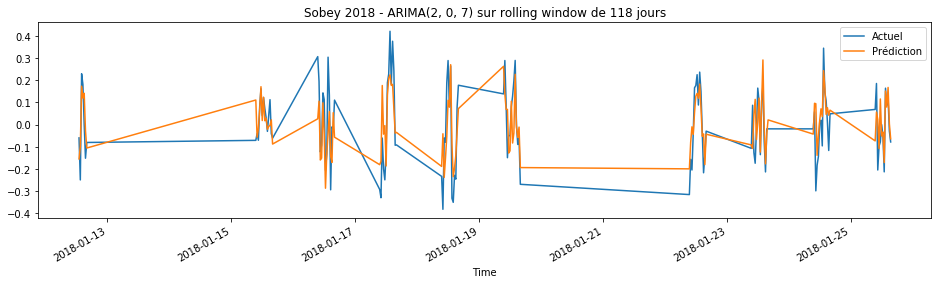

In [168]:
print("Moyenne de l'erreur: {:.3f}% ".format(sobey2018_6_meanDevB['Erreur'].mean()))
print("Écart type de l'erreur: {:.3f}%".format(sobey2018_6_meanDevB['Erreur'].std()))
print('____________________________')
print("Retour moyen actuel: {:.3f}% ".format(sobey2018_6_meanDevB['pct6'].mean()))
print("Retour moyen prédit: {:.3f}% ".format(sobey2018_6_meanDevB['Pred_pct6'].mean()))
print("Écart type des retours actuels: {:.3f}%".format(sobey2018_6_meanDevB['pct6'].std()))
print("Écart type des retours prédits: {:.3f}% ".format(sobey2018_6_meanDevB['Pred_pct6'].std()))

_= sobey2018_6_meanDevB[['pct6', 'Pred_pct6']].plot(figsize= (16, 4))
_= plt.legend(('Actuel', 'Prédiction'))
_= plt.title('Sobey 2018 - ARIMA(2, 0, 7) sur rolling window de 118 jours')
plt.plot()

In [ ]:
sobey2018_6_meanDev = tfrm_to_MinusMean(sobey2018['pct6'], window_size= 2)
sobey2018_6_meanDev.dropna(inplace= True)

In [171]:
range= list(np.arange(110, 126, 2))
ls_mean= []
ls_std= []

for i in range:
    # Entrainer un modèle ARIMA sur un rolling window
    test_df_roll= rolwin_ARIMA(sobey2018_6_meanDev, ARIMA_order= (2, 0, 7), window_size= i)
    ls_mean.append(test_df_roll['Erreur'].mean())
    ls_std.append(test_df_roll['Erreur'].std())
    
    print("___{} sur un Rolling window de: {}___".format('BA_2016_pct5_meanDev', i))
    print("Moyenne du delta Réel vs Prédiction: {:.3f} ".format(test_df_roll['Erreur'].mean()))
    print("Écart type du delta Réel vs Prédiction: {:.3f}".format(test_df_roll['Erreur'].std()))
    print("Écart type des données: {:.3f}".format(test_df_roll['Adj Close'].std()))
    #_= test_df_roll[['Adj Close', 'Prediction']].plot()

___BA_2016_pct5_meanDev sur un Rolling window de: 110___
Moyenne du delta Réel vs Prédiction: -0.001 
Écart type du delta Réel vs Prédiction: 0.199


KeyError: 'Adj Close'